In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [ ]:
def customer(env, name, server, arrival_rate, wait_times):
    """Customer process: arrives, waits, and gets served."""
    arrival_time = env.now

    with server.request() as request:
        yield request  # Wait for a free server
        wait_time = env.now - arrival_time  # Time spent waiting in the queue
        wait_times.append(wait_time)  # Record waiting time
        service_time = np.random.exponential(1 / SERVICE_RATE)
        yield env.timeout(service_time)  # Time spent being served

def arrival_generator(env, server, arrival_rate, wait_times):
    """Generate customers arriving at a random interval."""
    while True:
        yield env.timeout(np.random.exponential(1 / arrival_rate))
        env.process(customer(env, f"Customer-{env.now}", server, arrival_rate, wait_times))

def simulate(n_servers, arrival_rate, sim_time):
    """Simulate an M/M/n queue."""
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=n_servers)  # n servers
    wait_times = []  # Collect wait times for analysis
    env.process(arrival_generator(env, server, arrival_rate, wait_times))
    env.run(until=sim_time)
    return np.mean(wait_times), len(wait_times)

def prio_customer(env, name, server, arrival_rate, wait_times):
    """Customer process: arrives, waits, and gets served. Using priority service time."""
    arrival_time = env.now
    service_time = np.random.exponential(1 / SERVICE_RATE)
    with server.request(priority=service_time) as request:
        yield request  # Wait for a free server
        wait_time = env.now - arrival_time  # Time spent waiting in the queue
        wait_times.append(wait_time)  # Record waiting time
        yield env.timeout(service_time)  # Time spent being served

def prio_arrival_generator(env, server, arrival_rate, wait_times):
    """Generate customers arriving at a random interval."""
    while True:
        yield env.timeout(np.random.exponential(1 / arrival_rate))
        env.process(prio_customer(env, f"Customer-{env.now}", server, arrival_rate, wait_times))

def prio_simulate(n_servers, arrival_rate, sim_time):
    """Simulate an M/M/n queue."""
    env = simpy.Environment()
    server = simpy.PriorityResource(env, capacity=n_servers)  # n servers
    wait_times = []  # Collect wait times for analysis
    env.process(prio_arrival_generator(env, server, arrival_rate, wait_times))
    env.run(until=sim_time)
    return np.mean(wait_times), len(wait_times)


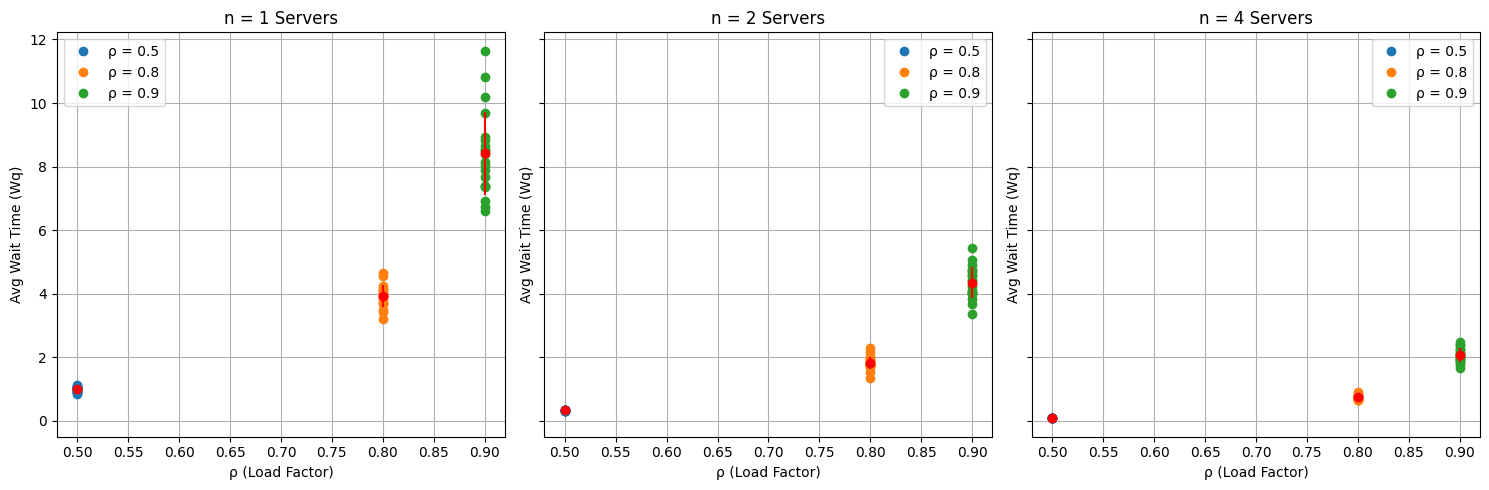

In [3]:
# Parameters
RANDOM_SEED = 42
SIM_TIME = 10000  # Simulation time in units
ARRIVAL_RATES = [0.5, 0.8, 0.9]  # ρ values
SERVICE_RATE = 1.0  # μ (service rate per server)
N_RUNS = 20  # Number of stochastic runs per configuration

# Stochastic simulation across multiple runs
def stochastic_simulation(n_servers, rho_values, n_runs, sim_time):
    results = {rho: [] for rho in rho_values}
    for rho in rho_values:
        arrival_rate = rho * n_servers * SERVICE_RATE
        for _ in range(n_runs):
            avg_wait, _ = simulate(n_servers, arrival_rate, sim_time)
            results[rho].append(avg_wait)
    return results

# Main simulation and plotting
np.random.seed(RANDOM_SEED)
n_servers_list = [1, 2, 4]
fig, axes = plt.subplots(1, len(n_servers_list), figsize=(15, 5), sharey=True)
for i, n_servers in enumerate(n_servers_list):
    results = stochastic_simulation(n_servers, ARRIVAL_RATES, N_RUNS, SIM_TIME)
    
    # Plot results
    axes[i].set_title(f"n = {n_servers} Servers")
    for rho in ARRIVAL_RATES:
        avg_waits = results[rho]
        axes[i].plot([rho] * len(avg_waits), avg_waits, 'o', label=f"ρ = {rho}")
        # Show mean and std deviation as a summary
        mean_wait = np.mean(avg_waits)
        std_wait = np.std(avg_waits)
        axes[i].errorbar(rho, mean_wait, yerr=std_wait, fmt='o', color='red')
    axes[i].set_xlabel("ρ (Load Factor)")
    axes[i].set_ylabel("Avg Wait Time (Wq)")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()


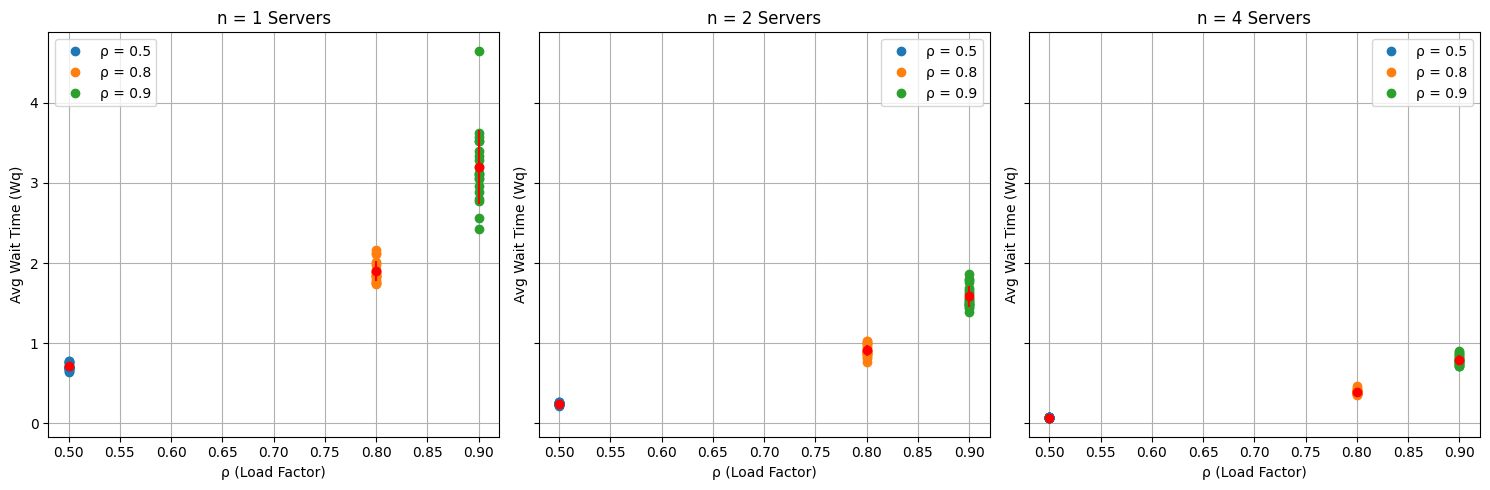

In [4]:
# Parameters
RANDOM_SEED = 42
SIM_TIME = 10000  # Simulation time in units
ARRIVAL_RATES = [0.5, 0.8, 0.9]  # ρ values
SERVICE_RATE = 1.0  # μ (service rate per server)
N_RUNS = 20  # Number of stochastic runs per configuration

# Stochastic simulation across multiple runs
def stochastic_simulation(n_servers, rho_values, n_runs, sim_time):
    results = {rho: [] for rho in rho_values}
    for rho in rho_values:
        arrival_rate = rho * n_servers * SERVICE_RATE
        for _ in range(n_runs):
            avg_wait, _ = prio_simulate(n_servers, arrival_rate, sim_time)
            results[rho].append(avg_wait)
    return results

# Main simulation and plotting
np.random.seed(RANDOM_SEED)
n_servers_list = [1, 2, 4]
fig, axes = plt.subplots(1, len(n_servers_list), figsize=(15, 5), sharey=True)
for i, n_servers in enumerate(n_servers_list):
    results = stochastic_simulation(n_servers, ARRIVAL_RATES, N_RUNS, SIM_TIME)
    
    # Plot results
    axes[i].set_title(f"n = {n_servers} Servers")
    for rho in ARRIVAL_RATES:
        avg_waits = results[rho]
        axes[i].plot([rho] * len(avg_waits), avg_waits, 'o', label=f"ρ = {rho}")
        # Show mean and std deviation as a summary
        mean_wait = np.mean(avg_waits)
        std_wait = np.std(avg_waits)
        axes[i].errorbar(rho, mean_wait, yerr=std_wait, fmt='o', color='red')
    axes[i].set_xlabel("ρ (Load Factor)")
    axes[i].set_ylabel("Avg Wait Time (Wq)")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
def conduct_t_test(amount_runs=20):
    """
    This function conducts a t test for all combinations of n_servers and ρ values.
    It returns the results of the simulation and the t test.

    :param amount_runs: the amount of runs to conduct for each combination

    :return: results, t_test_results
    """
    # set the seed
    np.random.seed(RANDOM_SEED)

    results = {n: {p: [] for p in ARRIVAL_RATES} for n in n_servers_list}

    # conduct the simulations and save the results
    for n_servers in n_servers_list:
        for i, p in enumerate(ARRIVAL_RATES):
            # get the results for the first p
            for i in range(amount_runs):
                avg_wait, _ = simulate(n_servers, p, SIM_TIME)
                results[n_servers][p].append(avg_wait)

    t_test_results = {}
    # conduct the t tests
    for n1 in n_servers_list:
        for n2 in n_servers_list:
            if n1 != n2:
                for p in ARRIVAL_RATES:
                    t_stat, p_value = ttest_ind(results[n1][p], results[n2][p])
                    t_test_results[(n1, n2, p)] = (t_stat, p_value)
                    if p_value < 0.05:
                        print("Significant difference between n={} and n={} for ρ={} with a p_value of {}".format(n1, n2, p, p_value))

    return results, t_test_results

results, t_test_results = conduct_t_test(amount_runs=20)